In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare flux data


In [2]:
ec = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/AMF_US-Ha1_FLUXNET_SUBSET_WW_1991-2020_3-5.csv"
)
ec["t1"] = pd.to_datetime(ec["TIMESTAMP_START"], format="%Y%m%d")
ec["t2"] = pd.to_datetime(ec["TIMESTAMP_END"], format="%Y%m%d")

Prepare MODIS data FPAR


In [17]:
modis_fpar = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha1-MYD15A2H-061-results.csv"
)
# filter based on QC flags
filtered_fpar = modis_fpar[
    (modis_fpar["MYD15A2H_061_FparLai_QC_MODLAND"] == "0b0")
    & (modis_fpar["MYD15A2H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (modis_fpar["MYD15A2H_061_FparLai_QC_CloudState"] == "0b00")
    & (modis_fpar["MYD15A2H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
]
filtered_fpar["time"] = pd.to_datetime(filtered_fpar["Date"])
# filtered_modis.set_index('time', inplace=True)

/tmp/ipykernel_3323924/2309316431.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fpar['time'] = pd.to_datetime(filtered_fpar['Date'])


In [23]:
modis_refl = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha1-MYD09A1-061-results.csv"
)
modis_refl["time"] = pd.to_datetime(modis_refl["Date"])

In [27]:
selected_fpar_data = pd.DataFrame()
selected_ec_data = pd.DataFrame()
selected_refl_data = pd.DataFrame()
for index, ec_row in ec.iterrows():
    start_date = ec["t1"][index]
    end_date = ec["t2"][index]
    mask_fpar = (filtered_fpar["time"] >= start_date) & (
        filtered_fpar["time"] <= end_date
    )
    if (mask_fpar == True).any():
        fpar_within_week = filtered_fpar[mask_fpar]
        selected_fpar_data = pd.concat([selected_fpar_data, fpar_within_week])
        selected_ec_data = pd.concat([selected_ec_data, ec.iloc[[index]]])
        associated_modis_refl = modis_refl[
            (modis_refl["time"] >= start_date) & (modis_refl["time"] <= end_date)
        ]
        selected_refl_data = pd.concat([selected_refl_data, associated_modis_refl])
        continue

In [83]:
gpp = selected_ec_data["GPP_NT_VUT_REF"].values
par = selected_ec_data["PPFD_IN"].values
fpar = selected_fpar_data["MYD15A2H_061_Fpar_500m"].values
red = selected_refl_data["MYD09A1_061_sur_refl_b01"].values
nir = selected_refl_data["MYD09A1_061_sur_refl_b02"].values
ndvi = (nir - red) / (nir + red)
fesc = (ndvi * nir) / fpar
lue = gpp / (fpar * par)

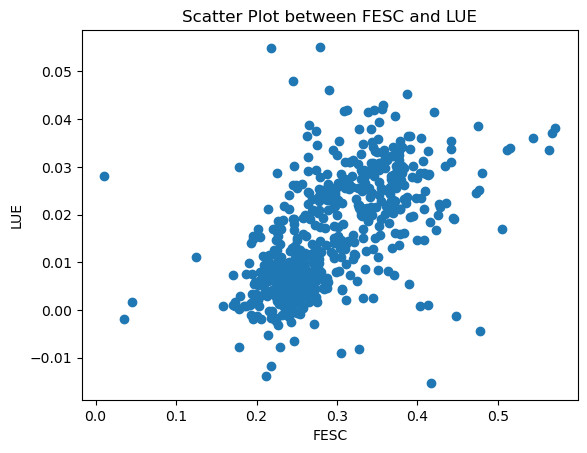

R-squared: 0.32346755666809685


In [85]:
from scipy.stats import zscore, linregress

# Combine FESC and LUE into a single DataFrame
scatter_data = pd.DataFrame({"FESC": fesc, "LUE": lue})

# Remove outliers using z-score
z_scores = zscore(scatter_data)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)  # Adjust the threshold as needed
filtered_data = scatter_data[filtered_entries]

# Create a scatter plot
plt.scatter(filtered_data["FESC"], filtered_data["LUE"])
plt.xlabel("FESC")
plt.ylabel("LUE")
plt.title("Scatter Plot between FESC and LUE")
plt.show()

# Calculate R-squared
slope, intercept, r_value, p_value, std_err = linregress(
    filtered_data["FESC"], filtered_data["LUE"]
)
r_squared = r_value**2
print(f"R-squared: {r_squared}")

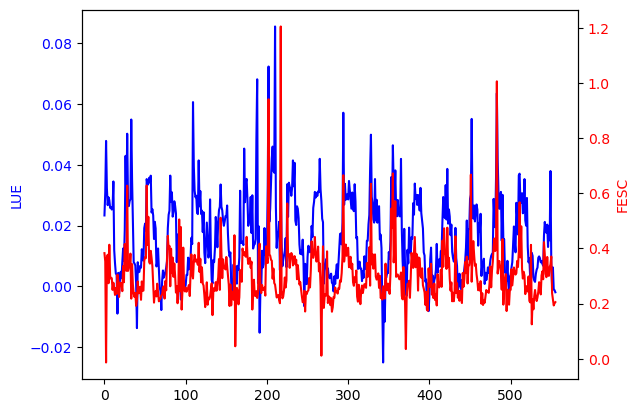

In [88]:
# Create a figure and a subplot (axis)
fig, ax1 = plt.subplots()

# Plot 'lue' on the first axis
ax1.plot(lue, color="blue")
ax1.set_ylabel("LUE", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot 'fesc' on the second axis
ax2.plot(fesc, color="red")
ax2.set_ylabel("FESC", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Display the plot
plt.show()

In [26]:
index = 1000
start_date = ec["t1"][index]
end_date = ec["t2"][index]
print(start_date, end_date)
modis_refl[(modis_refl["time"] >= start_date) & (modis_refl["time"] <= end_date)]

2010-03-26 00:00:00 2010-04-01 00:00:00


,Category,ID,Latitude,Longitude,Date,MODIS_Tile,MYD09A1_061_Line_Y_500m,MYD09A1_061_Sample_X_500m,MYD09A1_061_sur_refl_b01,MYD09A1_061_sur_refl_b02,...,MYD09A1_061_sur_refl_qc_500m_band_5_data_quality_four_bit_range_Description,MYD09A1_061_sur_refl_qc_500m_band_6_data_quality_four_bit_range,MYD09A1_061_sur_refl_qc_500m_band_6_data_quality_four_bit_range_Description,MYD09A1_061_sur_refl_qc_500m_band_7_data_quality_four_bit_range,MYD09A1_061_sur_refl_qc_500m_band_7_data_quality_four_bit_range_Description,MYD09A1_061_sur_refl_qc_500m_atmospheric_correction_performed,MYD09A1_061_sur_refl_qc_500m_atmospheric_correction_performed_Description,MYD09A1_061_sur_refl_qc_500m_adjacency_correction_performed,MYD09A1_061_sur_refl_qc_500m_adjacency_correction_performed_Description,time
356,DBF,US-Ha1,42.5378,-72.1715,2010-03-30,h12v04,1790.0,1637.0,0.0526,0.2126,...,highest quality,0b0000,highest quality,0b0000,highest quality,0b1,yes,0b0,no,2010-03-30
